In [8]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
      waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
      # Take a sample of the generated waveform to mitigate kernel resets
      waveform_short = waveform[:seconds*_SAMPLING_RATE]
      return display.Audio(waveform_short, rate=_SAMPLING_RATE, autoplay=True)

data_dir = pathlib.Path('data/maestro-v2.0.0')

filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

sample_file = filenames[1]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file) 
# waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
# # Take a sample of the generated waveform to mitigate kernel resets
# waveform_short = waveform[:30*_SAMPLING_RATE]
# t = display.Audio(waveform_short, rate=_SAMPLING_RATE, autoplay=True)
# t

aud  = display_audio(pm)
aud

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

Number of files: 1282
data/maestro-v2.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi
Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=75, note_name=D#5, duration=0.0677
1: pitch=63, note_name=D#4, duration=0.0781
2: pitch=75, note_name=D#5, duration=0.0443
3: pitch=63, note_name=D#4, duration=0.0469
4: pitch=75, note_name=D#5, duration=0.0417
5: pitch=63, note_name=D#4, duration=0.0469
6: pitch=87, note_name=D#6, duration=0.0443
7: pitch=99, note_name=D#7, duration=0.0690
8: pitch=87, note_name=D#6, duration=0.0378
9: pitch=99, note_name=D#7, duration=0.0742


,pitch,start,end,step,duration
0,63,1.001302,1.079427,0.000000,0.078125
1,75,1.006510,1.074219,0.005208,0.067708
2,75,1.305990,1.350260,0.299479,0.044271
3,63,1.305990,1.352865,0.000000,0.046875
4,75,1.630208,1.671875,0.324219,0.041667


In [9]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#5', 'D#5', 'D#4', 'D#5', 'D#4', 'D#7', 'D#6', 'D#7',
       'D#6'], dtype='<U3')

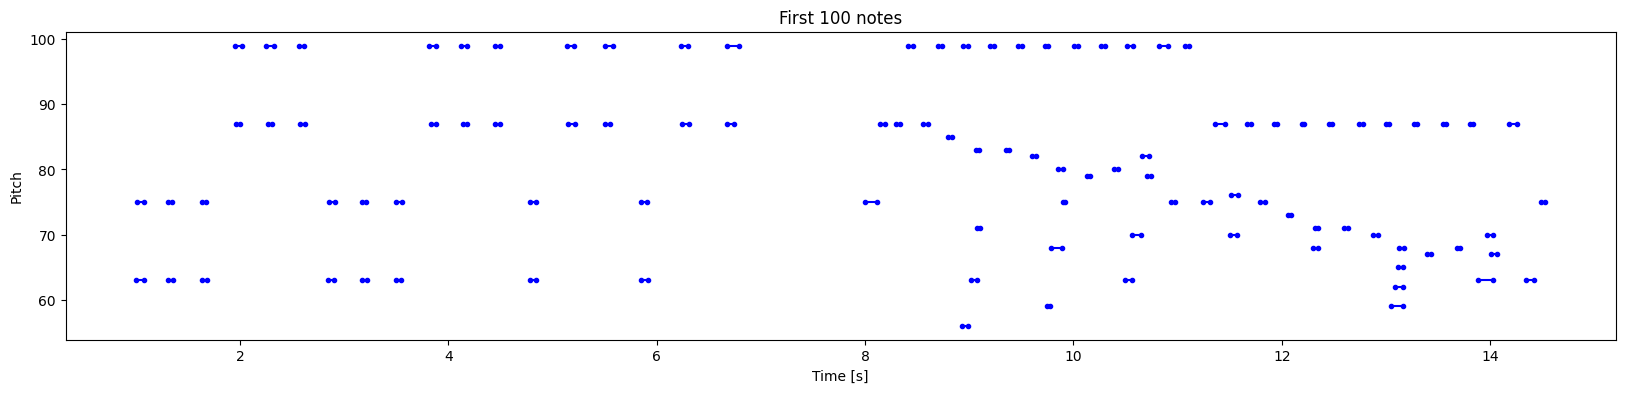

In [11]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(raw_notes, count=100)

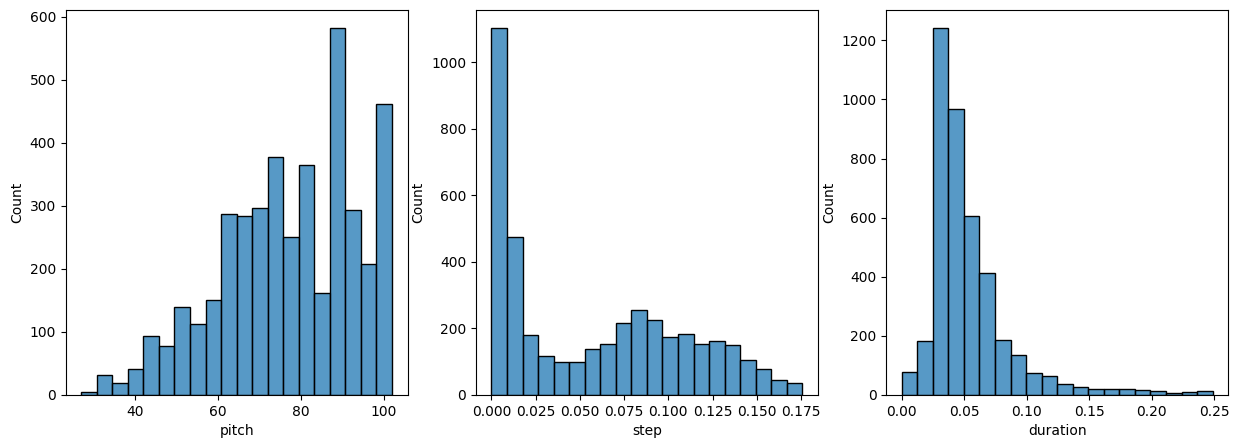

In [12]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

plot_distributions(raw_notes)